# Gridpoint env precursor analysis


* So far using CAPE/TCWV
* 1d/2d histograms
* Filter on fractional growth rate values.
* My initial impressions are that neither CAPE nor TCWV are strongly correlated with MCS area, or growth rates.
* TODO: Try subsetting tracks to e.g. tropics?


* 19/8/22: Initial work. Basic match up of tracks data and era5 tracks linked data.

In [2]:
from pathlib import Path

import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import numpy as np
import pandas as pd
import xarray as xr

from mcs_prime import McsTracks
from mcs_prime.mcs_prime_config import PATHS

from remake import load_remake

/home/users/mmuetz/miniconda3/envs/mcs_prime_env/lib/python3.10/site-packages/pyproj/__init__.py:89: UserWarning: pyproj unable to set database path.
  _pyproj_global_context_initialize()


In [3]:
tracks = McsTracks.open(PATHS['statsdir'] / 'mcs_tracks_final_extc_20190101.0000_20200101.0000.nc', 
                        PATHS['pixeldir'])
ntracks = len(tracks.dstracks.tracks)

In [62]:
# Produced by remakefiles/track_era5_env_precursor.py
track_era5 = xr.open_dataset(PATHS['datadir'] / 'mcs_prime_output/track_era5_env_precursor/2019' / 'daily_track_era5_data_2019.nc')

In [63]:
mask = ~np.isnan(track_era5.cape)
m2 = ~np.isnan(track_era5.tcwv)
(mask == m2).all()

<xarray.DataArray ()>
array(True)

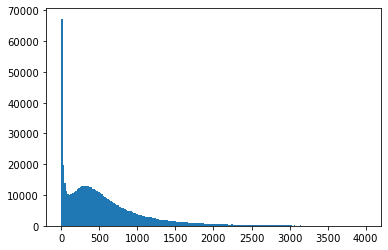

In [64]:
plt.hist(track_era5.cape.values[mask], bins=np.linspace(0, 4000, 200));

Large spike at CAPE=0

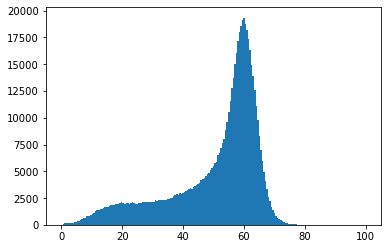

In [65]:
plt.hist(track_era5.tcwv.values[mask], bins=np.linspace(0, 100, 200));

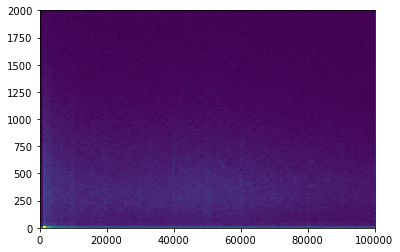

In [66]:
plt.hist2d(tracks.dstracks.area.values[mask], track_era5.cape.values[mask], bins=(np.linspace(0, 1e5, 100), np.linspace(0, 2000, 100)));

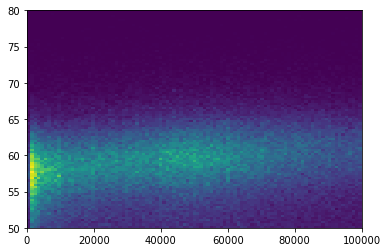

In [67]:
plt.hist2d(tracks.dstracks.area.values[mask], track_era5.tcwv.values[mask], bins=(np.linspace(0, 1e5, 100), np.linspace(50, 80, 100)));

In [68]:
dt = 1
fractional_area_growth = tracks.dstracks.area.values.copy()
fractional_area_growth[:, 1:] = (1 / tracks.dstracks.area[:, 1:].values) * ((tracks.dstracks.area[:, 1:].values - tracks.dstracks.area[:, :-1].values) / dt)

In [69]:
area_mask = mask.copy()
area_mask[:, 0] = False

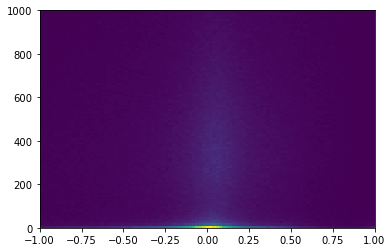

In [70]:
plt.hist2d(fractional_area_growth[area_mask], track_era5.cape.values[area_mask], bins=(np.linspace(-1, 1, 100), np.linspace(0, 1000, 100)));

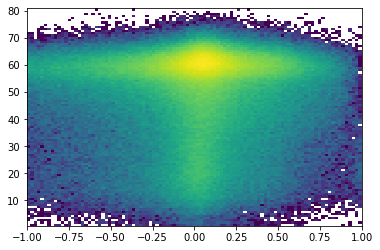

In [71]:
plt.hist2d(fractional_area_growth[area_mask], track_era5.tcwv.values[area_mask], bins=(np.linspace(-1, 1, 100), 100), norm=LogNorm());

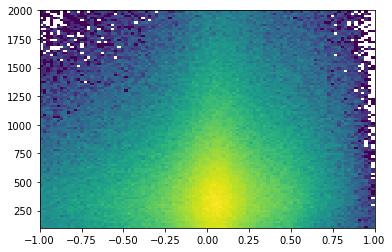

In [72]:
plt.hist2d(fractional_area_growth[area_mask], track_era5.cape.values[area_mask], bins=(np.linspace(-1, 1, 100), np.linspace(100, 2000, 100)), norm=LogNorm());

In [73]:
early_mask = area_mask.copy()
early_mask[:, 4:] = False

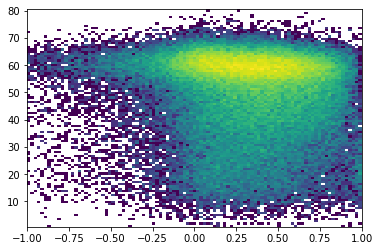

In [74]:
plt.hist2d(fractional_area_growth[early_mask], track_era5.tcwv.values[early_mask], bins=(np.linspace(-1, 1, 100), 100), norm=LogNorm());

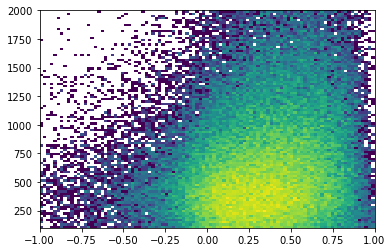

In [75]:
plt.hist2d(fractional_area_growth[early_mask], track_era5.cape.values[early_mask], bins=(np.linspace(-1, 1, 100), np.linspace(100, 2000, 100)), norm=LogNorm());

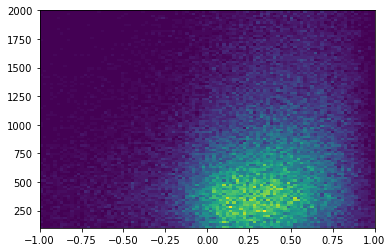

In [76]:
plt.hist2d(fractional_area_growth[early_mask], track_era5.cape.values[early_mask], bins=(np.linspace(-1, 1, 100), np.linspace(100, 2000, 100)));

In [77]:
thresh = 0.1  # roughly equal numbers in each.
growth_mask = fractional_area_growth > thresh
decay_mask = fractional_area_growth < -thresh
stable_mask = (fractional_area_growth >= -thresh) & (fractional_area_growth <= thresh)
print(growth_mask.sum())
print(stable_mask.sum())
print(decay_mask.sum())

257003
172820
201163


741.3161
646.8995
668.6391


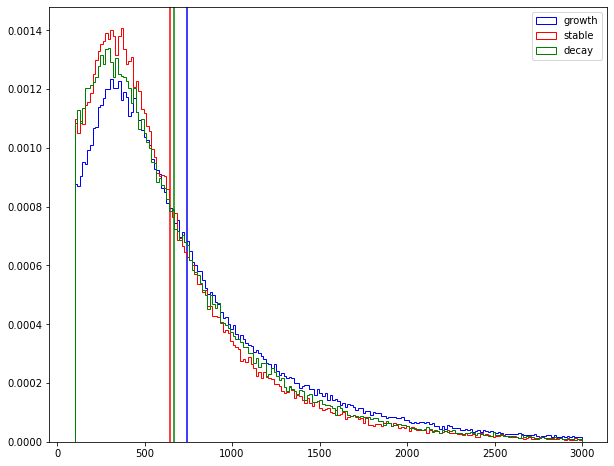

In [78]:
plt.figure(figsize=(10, 8))
for l, m, c in [('growth', growth_mask, 'b'), ('stable', stable_mask, 'r'), ('decay', decay_mask, 'g')]:
    data = track_era5.cape.values[m & mask]
    mean = data[data > 100].mean()
    p = plt.hist(data, bins=np.linspace(100, 3000, 200), histtype='step', density=True, label=l, color=c);
    plt.axvline(x=mean, color=c)
    print(mean)
plt.legend()


51.071934
50.468456
50.15858


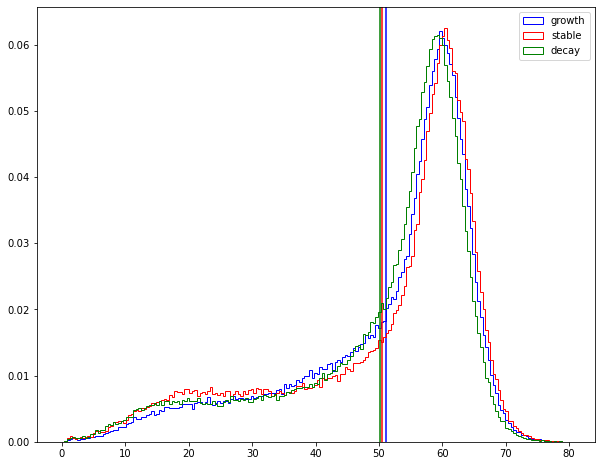

In [79]:
plt.figure(figsize=(10, 8))
for l, m, c in [('growth', growth_mask, 'b'), ('stable', stable_mask, 'r'), ('decay', decay_mask, 'g')]:
    data = track_era5.tcwv.values[m & mask]
    mean = data.mean()
    p = plt.hist(data, bins=np.linspace(0, 80, 200), histtype='step', density=True, label=l, color=c);
    plt.axvline(x=mean, color=c)
    print(mean)
plt.legend()


## Similar, but for shear at different levels.

In [35]:
teep = load_remake('../../remakefiles/track_era5_env_precursor.py')

In [36]:
task = teep.CombineTrackERA5EnvPrecursor.tasks.filter(year=2019, datatype='shear')[0]

In [81]:
path = task.outputs['track_era5_data']
# path = Path('/gws/nopw/j04/mcsprime/mmuetz/data/mcs_prime_output/track_era5_env_precursor/2019/daily_track_era5_data_shear_2019_batch-00.nc')  # Temp data.
path.exists()

True

In [82]:
# Produced by remakefiles/track_era5_env_precursor.py
track_era5uv = xr.open_dataset(path)

In [83]:
track_era5uv

<xarray.Dataset>
Dimensions:  (tracks: 32843, times: 400, level: 4)
Coordinates:
  * tracks   (tracks) int64 0 1 2 3 4 5 ... 32837 32838 32839 32840 32841 32842
  * times    (times) int64 0 1 2 3 4 5 6 7 8 ... 392 393 394 395 396 397 398 399
  * level    (level) int64 133 111 96 74
Data variables:
    u        (tracks, times, level) float64 ...
    v        (tracks, times, level) float64 ...
Attributes:
    num_filtered_points:  16

In [40]:
track_era5uv.level

<xarray.DataArray 'level' (level: 4)>
array([133, 111,  96,  74])
Coordinates:
  * level    (level) int64 133 111 96 74

In [84]:
u = track_era5uv.u.values
v = track_era5uv.v.values

In [85]:
u.shape

(32843, 400, 4)

In [86]:
# Calc LLS, MLS, HLS, DS in one line.
# LLS = shear[:, :, 0]
# MLS = shear[:, :, 1]
# HLS = shear[:, :, 2]
# DS = shear[:, :, 3]
shear = np.sqrt((np.roll(u, -1, axis=2) - u)**2 + (np.roll(v, -1, axis=2) - v)**2)
lls, mls, hls, ds = [shear[:, :, i] for i in range(4)]

In [87]:
for i in range(3):
    print(np.sqrt((u[0, 0, i + 1] - u[0, 0, i])**2 + (v[0, 0, i + 1] - v[0, 0, i])**2))
print(np.sqrt((u[0, 0, -1] - u[0, 0, 0])**2 + (v[0, 0, -1] - v[0, 0, 0])**2))

6.397493219210358
11.436124228450096
3.7842360192913382
16.436096322648726


In [88]:
shear[0, 0, :]

array([ 6.39749322, 11.43612423,  3.78423602, 16.43609632])

In [89]:
mask = ~np.isnan(lls)

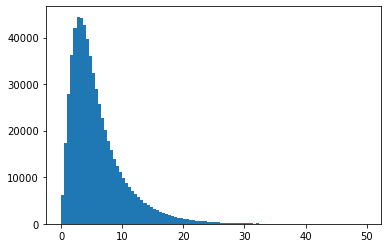

In [90]:
plt.hist(lls[mask], bins=100);

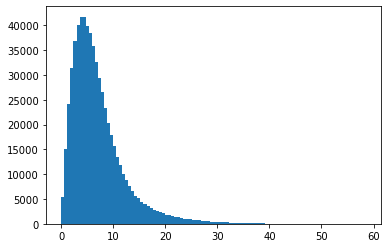

In [91]:
plt.hist(mls[mask], bins=100);

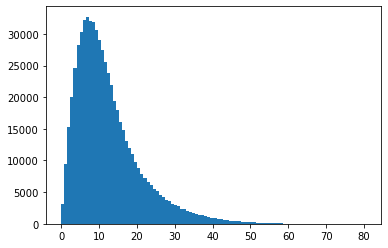

In [92]:
plt.hist(hls[mask], bins=100);

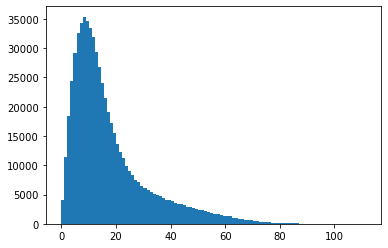

In [93]:
plt.hist(ds[mask], bins=100);

5.673560011320987
6.219640644412018
5.866174422273171


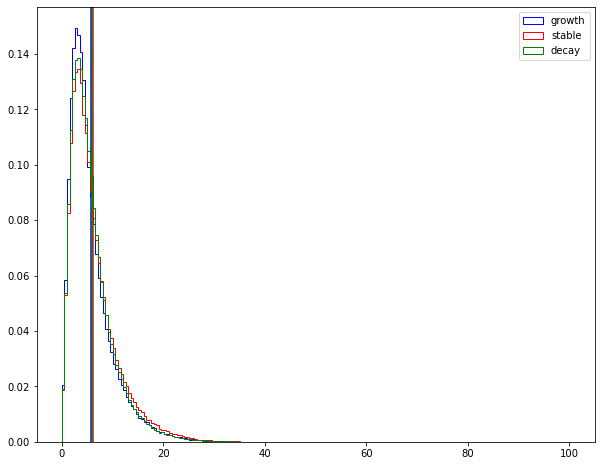

In [95]:
plt.figure(figsize=(10, 8))
for l, m, c in [('growth', growth_mask, 'b'), ('stable', stable_mask, 'r'), ('decay', decay_mask, 'g')]:
    data = lls[m & mask]
    mean = data.mean()
    p = plt.hist(data, bins=np.linspace(0, 100, 200), histtype='step', density=True, label=l, color=c);
    plt.axvline(x=mean, color=c)
    print(mean)
plt.legend()


6.959798078171436
7.518914027027453
6.926182857696981


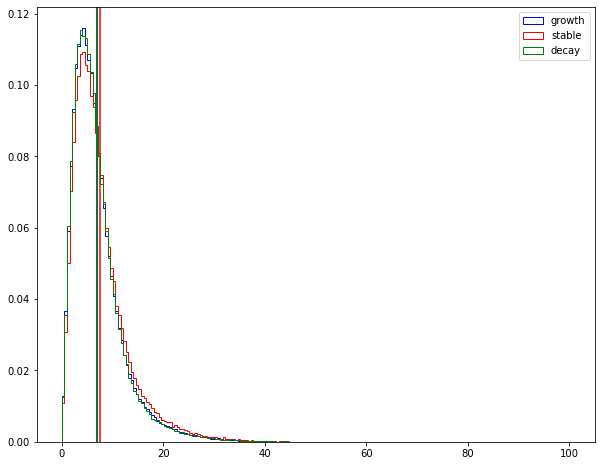

In [96]:
plt.figure(figsize=(10, 8))
for l, m, c in [('growth', growth_mask, 'b'), ('stable', stable_mask, 'r'), ('decay', decay_mask, 'g')]:
    data = mls[m & mask]
    mean = data.mean()
    p = plt.hist(data, bins=np.linspace(0, 100, 200), histtype='step', density=True, label=l, color=c);
    plt.axvline(x=mean, color=c)
    print(mean)
plt.legend()


12.396895053058296
12.779025558936988
12.127641557199283


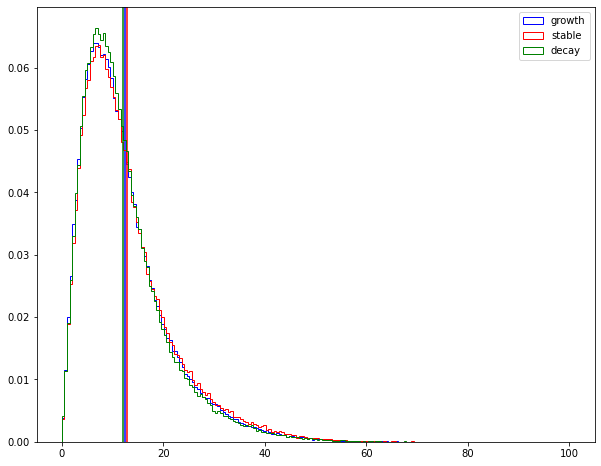

In [97]:
plt.figure(figsize=(10, 8))
for l, m, c in [('growth', growth_mask, 'b'), ('stable', stable_mask, 'r'), ('decay', decay_mask, 'g')]:
    data = hls[m & mask]
    mean = data.mean()
    p = plt.hist(data, bins=np.linspace(0, 100, 200), histtype='step', density=True, label=l, color=c);
    plt.axvline(x=mean, color=c)
    print(mean)
plt.legend()


17.5137411234807
18.75488759692049
16.98026171591831


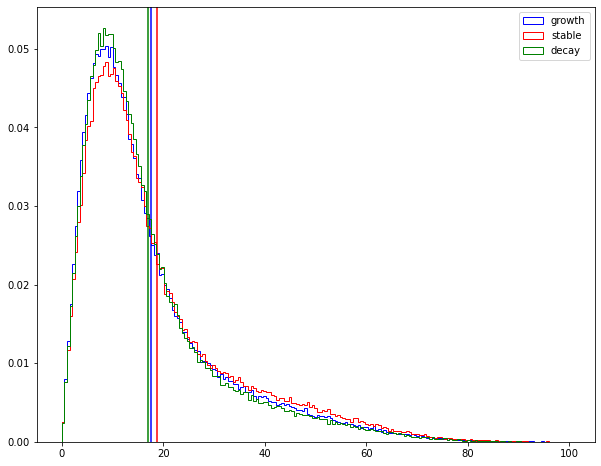

In [98]:
plt.figure(figsize=(10, 8))
for l, m, c in [('growth', growth_mask, 'b'), ('stable', stable_mask, 'r'), ('decay', decay_mask, 'g')]:
    data = ds[m & mask]
    mean = data.mean()
    p = plt.hist(data, bins=np.linspace(0, 100, 200), histtype='step', density=True, label=l, color=c);
    plt.axvline(x=mean, color=c)
    print(mean)
plt.legend()
